In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_test_features.csv')
census_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
holdout_data.drop('Unnamed: 0', axis=1, inplace=True)

holdout_data.shape

(4323, 20)

# Removing Outliers

In [3]:
def clean_beds(dataframe):
    median_beds = dataframe.bedrooms.median()
    dataframe['bedrooms'].values[dataframe['bedrooms'].values > 10] = median_beds
    print('Entries with an abnormal amount of bedrooms have been replaced with {}, the median number of bedrooms in the dataframe. \n'.format(median_beds))

In [4]:
clean_beds(holdout_data)

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 



# Adding Features

In [5]:
holdout_data['home_age'] =  2015 - holdout_data.yr_built
#holdout_data['available_housing'] = holdout_data['total_housing_units'] - holdout_data['occupied_housing_units']

#turning date into datetime so we can extract sale year/month
holdout_data['date'] = pd.to_datetime(holdout_data['date'])

holdout_data['sale_year'] = pd.DatetimeIndex(holdout_data['date']).year
holdout_data['sale_month'] = pd.DatetimeIndex(holdout_data['date']).month
holdout_data.drop(columns='date', inplace=True)

#### Dummy features

In [6]:
waterfront_dummies = pd.get_dummies(holdout_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(holdout_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(holdout_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(holdout_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(holdout_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(holdout_data['zipcode'], prefix='zip', drop_first=True)

In [7]:
holdout_data = holdout_data.drop(['id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
holdout_data = pd.concat([holdout_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)

# Removing Colinear Features

In [8]:
def multicolinear_features(data):
    '''
    input: dataframe
    returns a dataframe of all colinear features in a dataframe.
    '''

    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc']
    return df[(df.cc>.75) & (df.cc <1)]

In [9]:
multicolinear_features(holdout_data)

,cc
pairs,
"(home_age, yr_built)",1.000000
"(yr_built, home_age)",1.000000
"(sqft_living, sqft_above)",0.906526
"(sqft_above, sqft_living)",0.906526
"(condition_4, condition_3)",0.822208
"(condition_3, condition_4)",0.822208
"(sqft_living15, sqft_living)",0.763751
"(sqft_living, sqft_living15)",0.763751


In [10]:
holdout_data.drop([ 'sqft_living', 'condition_3'], axis=1, inplace=True)

In [11]:
multicolinear_features(holdout_data)

,cc
pairs,
"(home_age, yr_built)",1.0
"(yr_built, home_age)",1.0


# Adding poly features

In [12]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_feats.fit_transform(holdout_data)
poly_columns = poly_feats.get_feature_names(holdout_data.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.shape

(4323, 6440)

In [14]:
selected_columns = [
    'bedrooms',
 'bathrooms',
 'floors',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'waterf_1',
 'has_view_3',
 'has_view_4',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'zip_98004',
 'zip_98039',
 'zip_98040',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms floors',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms yr_built',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms sale_year',
 'bedrooms waterf_1',
 'bedrooms has_view_3',
 'bedrooms has_view_4',
 'bedrooms grade_6',
 'bedrooms grade_7',
 'bedrooms grade_9',
 'bedrooms grade_10',
 'bedrooms grade_11',
 'bedrooms grade_12',
 'bedrooms grade_13',
 'bedrooms zip_98004',
 'bedrooms zip_98039',
 'bedrooms zip_98040',
 'bedrooms zip_98112',
 'bathrooms^2',
 'bathrooms floors',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms yr_built',
 'bathrooms yr_renovated',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living15',
 'bathrooms home_age',
 'bathrooms sale_year',
 'bathrooms waterf_1',
 'bathrooms has_view_3',
 'bathrooms has_view_4',
 'bathrooms grade_6',
 'bathrooms grade_7',
 'bathrooms grade_9',
 'bathrooms grade_10',
 'bathrooms grade_11',
 'bathrooms grade_12',
 'bathrooms grade_13',
 'bathrooms zip_98004',
 'bathrooms zip_98039',
 'bathrooms zip_98040',
 'bathrooms zip_98112',
 'sqft_lot waterf_1',
 'sqft_lot grade_13',
 'sqft_lot zip_98004',
 'sqft_lot zip_98039',
 'sqft_lot zip_98040',
 'sqft_lot zip_98112',
 'floors^2',
 'floors sqft_above',
 'floors sqft_basement',
 'floors yr_built',
 'floors lat',
 'floors long',
 'floors sqft_living15',
 'floors sale_year',
 'floors waterf_1',
 'floors has_view_3',
 'floors has_view_4',
 'floors grade_6',
 'floors grade_7',
 'floors grade_9',
 'floors grade_10',
 'floors grade_11',
 'floors grade_12',
 'floors grade_13',
 'floors zip_98004',
 'floors zip_98039',
 'floors zip_98040',
 'floors zip_98112',
 'sqft_above^2',
 'sqft_above sqft_basement',
 'sqft_above yr_built',
 'sqft_above yr_renovated',
 'sqft_above lat',
 'sqft_above long',
 'sqft_above sqft_living15',
 'sqft_above home_age',
 'sqft_above sale_year',
 'sqft_above waterf_1',
 'sqft_above has_view_2',
 'sqft_above has_view_3',
 'sqft_above has_view_4',
 'sqft_above grade_6',
 'sqft_above grade_7',
 'sqft_above grade_9',
 'sqft_above grade_10',
 'sqft_above grade_11',
 'sqft_above grade_12',
 'sqft_above grade_13',
 'sqft_above zip_98004',
 'sqft_above zip_98039',
 'sqft_above zip_98040',
 'sqft_above zip_98112',
 'sqft_basement^2',
 'sqft_basement yr_built',
 'sqft_basement yr_renovated',
 'sqft_basement lat',
 'sqft_basement long',
 'sqft_basement sqft_living15',
 'sqft_basement home_age',
 'sqft_basement sale_year',
 'sqft_basement waterf_1',
 'sqft_basement has_view_3',
 'sqft_basement has_view_4',
 'sqft_basement grade_9',
 'sqft_basement grade_10',
 'sqft_basement grade_11',
 'sqft_basement grade_12',
 'sqft_basement grade_13',
 'sqft_basement zip_98004',
 'sqft_basement zip_98040',
 'yr_built sqft_living15',
 'yr_built waterf_1',
 'yr_built has_view_3',
 'yr_built has_view_4',
 'yr_built grade_6',
 'yr_built grade_7',
 'yr_built grade_9',
 'yr_built grade_10',
 'yr_built grade_11',
 'yr_built grade_12',
 'yr_built grade_13',
 'yr_built zip_98004',
 'yr_built zip_98039',
 'yr_built zip_98040',
 'yr_renovated sqft_living15',
 'lat^2',
 'lat long',
 'lat sqft_living15',
 'lat sale_year',
 'lat waterf_1',
 'lat has_view_3',
 'lat has_view_4',
 'lat grade_6',
 'lat grade_7',
 'lat grade_9',
 'lat grade_10',
 'lat grade_11',
 'lat grade_12',
 'lat grade_13',
 'lat zip_98004',
 'lat zip_98039',
 'lat zip_98040',
 'long sqft_living15',
 'long waterf_1',
 'long has_view_3',
 'long has_view_4',
 'long grade_6',
 'long grade_7',
 'long grade_9',
 'long grade_10',
 'long grade_11',
 'long grade_12',
 'long grade_13',
 'long zip_98004',
 'long zip_98039',
 'long zip_98040',
 'sqft_living15^2',
 'sqft_living15 home_age',
 'sqft_living15 sale_year',
 'sqft_living15 waterf_1',
 'sqft_living15 has_view_3',
 'sqft_living15 has_view_4',
 'sqft_living15 grade_6',
 'sqft_living15 grade_7',
 'sqft_living15 grade_9',
 'sqft_living15 grade_10',
 'sqft_living15 grade_11',
 'sqft_living15 grade_12',
 'sqft_living15 grade_13',
 'sqft_living15 zip_98004',
 'sqft_living15 zip_98039',
 'sqft_living15 zip_98040',
 'sqft_living15 zip_98112',
 'sqft_lot15 waterf_1',
 'sqft_lot15 has_view_4',
 'sqft_lot15 zip_98004',
 'sqft_lot15 zip_98039',
 'sqft_lot15 zip_98040',
 'sqft_lot15 zip_98112',
 'home_age waterf_1',
 'home_age has_view_4',
 'home_age grade_6',
 'home_age grade_7',
 'home_age grade_9',
 'home_age grade_10',
 'home_age grade_11',
 'home_age grade_12',
 'home_age grade_13',
 'home_age zip_98004',
 'sale_year waterf_1',
 'sale_year has_view_3',
 'sale_year has_view_4',
 'sale_year grade_6',
 'sale_year grade_7',
 'sale_year grade_9',
 'sale_year grade_10',
 'sale_year grade_11',
 'sale_year grade_12',
 'sale_year grade_13',
 'sale_year zip_98004',
 'sale_year zip_98039',
 'sale_year zip_98040',
 'waterf_1^2',
 'waterf_1 has_view_4',
 'waterf_1 grade_11',
 'waterf_1 grade_12',
 'has_view_3^2',
 'has_view_4^2',
 'has_view_4 grade_10',
 'has_view_4 grade_12',
 'grade_6^2',
 'grade_7^2',
 'grade_9^2',
 'grade_10^2',
 'grade_11^2',
 'grade_11 zip_98004',
 'grade_12^2',
 'grade_13^2',
 'zip_98004^2',
 'zip_98039^2',
 'zip_98040^2'
]

# Predicting on the holdout

In [15]:
import pickle

final_model = pickle.load(open('final_model.pickle', 'rb'))

In [16]:
preds = final_model.predict(df_poly[selected_columns])

In [17]:
predictions = pd.DataFrame(preds, columns=['holdout_pred'])

predictions.to_csv('housing_pred_Brendan_Ferris.csv')

In [18]:
predictions.sort_values(by='holdout_pred',ascending=True)

,holdout_pred
742,1.177035e+04
794,3.577547e+04
529,4.791009e+04
1427,5.609253e+04
1884,5.978512e+04
...,...
1192,3.011442e+06
1187,3.400511e+06
1858,3.580709e+06
1727,3.800000e+06


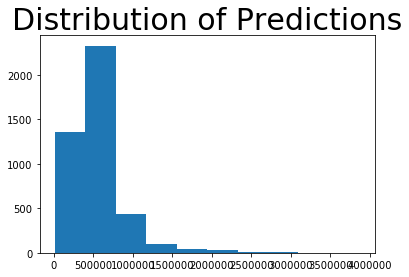

In [19]:
plt.hist(preds, bins=10);
plt.title('Distribution of Predictions', size=30);

In [20]:
preds

array([600222.56679344, 614643.79102182, 365600.13688183, ...,
       283726.94393396, 416977.77883053, 285244.70983934])

In [21]:
predictions.loc[3564][0]

682461.1760835648